Numeric features used: ['land_size_m2', 'building_size_m2', 'bedrooms', 'bathrooms', 'building_age']
Categorical features used: ['district', 'city', 'property_type', 'certificate', 'furnishing']
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best params: {'regressor__max_depth': None, 'regressor__min_samples_leaf': 1, 'regressor__n_estimators': 200}
Evaluation on test set:
 MAE : 0.20 (log-price)
 RMSE: 0.35 (log-price)
 R2  : 0.9012
5-fold CV R2 scores: [0.66136921 0.83409041 0.76873088 0.72419954 0.73012435]
CV R2 mean: 0.7437028766732696
Model saved to house_price_model_minimal.joblib
Selesai.


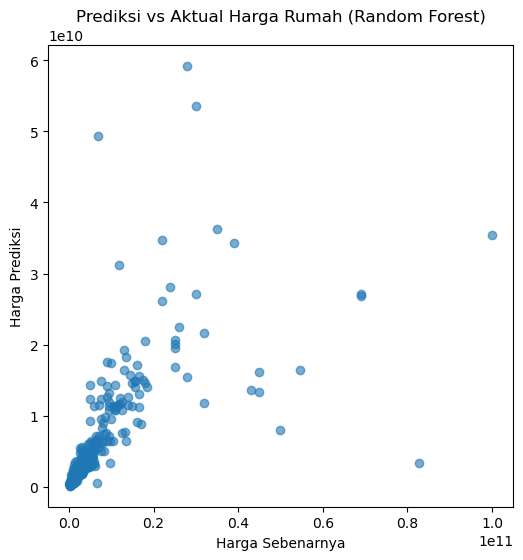

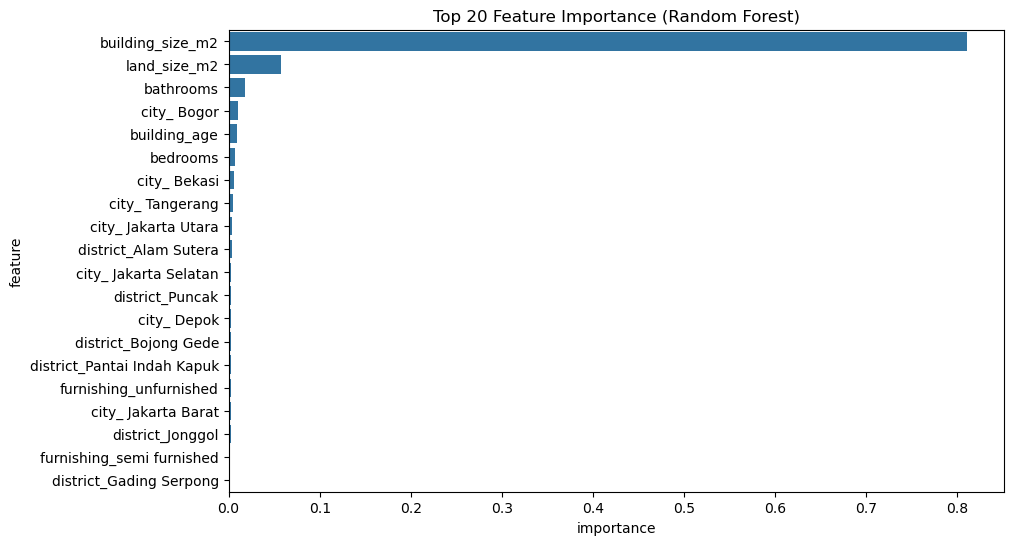

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

# ---------------------------
# Helper: convert angka dari string
# ---------------------------
def to_numeric_from_string(s):
    if pd.isnull(s):
        return np.nan
    if isinstance(s, (int, float, np.integer, np.floating)):
        return s
    s = str(s).replace(",", "")
    m = re.search(r'[-+]?\d*\.?\d+', s)
    return float(m.group()) if m else np.nan

def preprocess_dataframe(df):
    df = df.copy()
    df['price_in_rp'] = df['price_in_rp'].apply(to_numeric_from_string)

    for col in ['land_size_m2', 'building_size_m2',
                'bedrooms', 'bathrooms', 'building_age']:
        if col in df.columns:
            df[col] = df[col].apply(to_numeric_from_string)

    drop_cols = ['url', 'title', 'address', 'ads_id',
                 'lat', 'long', 'carports', 'electricity',
                 'maid_bedrooms', 'maid_bathrooms', 'floors',
                 'year_built', 'property_condition', 'building_orientation',
                 'facilities']
    df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors="ignore")
    return df

# ---------------------------
# Load data
# ---------------------------
df = pd.read_csv("jabodetabek_house_price.csv")
df = preprocess_dataframe(df)

# Target
target_col = "price_in_rp"
df = df.dropna(subset=[target_col])

# ---------------------------
# Feature selection (minimal)
# ---------------------------
numeric_features = ["land_size_m2", "building_size_m2", "bedrooms", "bathrooms", "building_age"]
categorical_features = ["district", "city", "property_type", "certificate", "furnishing"]

print("Numeric features used:", numeric_features)
print("Categorical features used:", categorical_features)

# ---------------------------
# Pipelines
# ---------------------------
numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, numeric_features),
    ("cat", categorical_pipeline, categorical_features)
])

# ---------------------------
# Model pipeline
# ---------------------------
model_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(random_state=42, n_jobs=-1))
])

# ---------------------------
# Train/test split
# ---------------------------
X = df.drop(columns=[target_col])
y = np.log1p(df[target_col].astype(float))  # log transform target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ---------------------------
# Hyperparameter tuning
# ---------------------------
param_grid = {
    "regressor__n_estimators": [100, 200],
    "regressor__max_depth": [None, 10, 20],
    "regressor__min_samples_leaf": [1, 2, 4]
}

grid = GridSearchCV(model_pipeline, param_grid, cv=5,
                    scoring="neg_mean_absolute_error",
                    n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
best_model = grid.best_estimator_

# ---------------------------
# Evaluation
# ---------------------------
y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred) ** 0.5
r2 = r2_score(y_test, y_pred)

print("Evaluation on test set:")
print(f" MAE : {mae:,.2f} (log-price)")
print(f" RMSE: {rmse:,.2f} (log-price)")
print(f" R2  : {r2:.4f}")

cv_scores = cross_val_score(best_model, X, y, cv=5, scoring="r2", n_jobs=-1)
print("5-fold CV R2 scores:", cv_scores)
print("CV R2 mean:", np.mean(cv_scores))

# ---------------------------
# Save model
# ---------------------------
joblib.dump(best_model, "house_price_model_minimal.joblib")
print("Model saved to house_price_model_minimal.joblib")

print("Selesai.")

# ---------------------------
# Visualisasi Prediksi vs Aktual
# ---------------------------
plt.figure(figsize=(6, 6))
plt.scatter(np.expm1(y_test), np.expm1(y_pred), alpha=0.6)
plt.xlabel("Harga Sebenarnya")
plt.ylabel("Harga Prediksi")
plt.title("Prediksi vs Aktual Harga Rumah (Random Forest)")
plt.show()

# ---------------------------
# Visualisasi Feature Importance
# ---------------------------
# Ambil nama feature dari preprocessor
ohe = best_model.named_steps["preprocessor"].named_transformers_["cat"].named_steps["onehot"]
cat_feature_names = ohe.get_feature_names_out(categorical_features)
num_feature_names = numeric_features
all_feature_names = np.concatenate([num_feature_names, cat_feature_names])

# Ambil importance dari RandomForest
importances = best_model.named_steps["regressor"].feature_importances_

# Buat DataFrame untuk importance
feat_imp = pd.DataFrame({
    "feature": all_feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

# Plot top 20
plt.figure(figsize=(10, 6))
sns.barplot(x="importance", y="feature", data=feat_imp.head(20))
plt.title("Top 20 Feature Importance (Random Forest)")
plt.show()
